In [1]:
def process_of_addition(num1, num2):
    num1_str, num2_str = str(num1), str(num2)
    max_len = max(len(num1_str), len(num2_str))

    # Adding leading zeros to make both numbers of equal length
    num1_str = num1_str.zfill(max_len)
    num2_str = num2_str.zfill(max_len)

    carry = 0
    current_sum = ''  # Initialize as an empty string
    result = []  # Initial state

    for i in range(max_len - 1, -1, -1):  # From rightmost digit to leftmost
        temp_sum = int(num1_str[i]) + int(num2_str[i]) + carry
        carry = 1 if temp_sum >= 10 else 0  # Update carry

        # Update current sum as a string, adding a new digit to the end
        current_sum = str(temp_sum % 10) + current_sum

        # Add the current state to the result
        num1_current = num1_str[i:] if num1_str[i:] else '0'
        num2_current = num2_str[i:] if num2_str[i:] else '0'
        result.append([num1_current, num2_current, str(carry), current_sum.zfill(max_len - i)])

    return result

def get_outputs(num1, num2):
    ls=process_of_addition(num1, num2)
    prompt_template1='{} + {}\nSolution: '
    prompt_template2='{} + {}\nSolution: Call: {} + {}\nReturn: Carry {}, Output {}\nAnswer: '
    final_template='Carry {}, Output {}'
    inter_template1='Call: {} + {}\n'
    inter_template2='Carry {}, Output {}'
    ret_ls=[]
    for i in range(len(ls)):
        if i==0:
            current=ls[0]
            ret_ls.append((prompt_template1.format(current[0],current[1]),final_template.format(current[2],current[3])))
            continue
        current=ls[i]
        prev=ls[i-1]
        prompt1=prompt_template1.format(current[0],current[1])
        output1=inter_template1.format(prev[0],prev[1])
        prompt2=prompt_template2.format(current[0],current[1],prev[0],prev[1],prev[2],prev[3])
        output2=inter_template2.format(current[2],current[3])
        ret_ls.append((prompt1,output1))
        ret_ls.append((prompt2,output2))
    return ret_ls

# Test the function
print(process_of_addition(9999, 1))


[['9', '1', '1', '0'], ['99', '01', '1', '00'], ['999', '001', '1', '000'], ['9999', '0001', '1', '0000']]


In [2]:
import random
pairs = \
[(random.randint(10**(i-1), 10**i), random.randint(10**(j-1), 10**j)) for i in range(1,16) for j in range(i,16) for k in range(1000)] +\
[(random.randint(10**(i-1), 10**i), random.randint(10**(j-1), 10**j)) for i in range(3,16) for j in range(i,16) for k in range(1000)] +\
[(random.randint(10**(i-1), 10**i), random.randint(10**(j-1), 10**j)) for i in range(6,16) for j in range(i,16) for k in range(1000)] +\
[(random.randint(10**(i-1), 10**i), random.randint(10**(j-1), 10**j)) for i in range(9,16) for j in range(i,16) for k in range(1000)] +\
[(random.randint(10**(i-1), 10**i), random.randint(10**(j-1), 10**j)) for i in range(12,16) for j in range(i,16) for k in range(1000)] 

random.shuffle(pairs)

print("Addition:", len(pairs))

data_add = []

for num1, num2 in pairs:
    
    if random.random()<0.5:
        num1, num2 = num2, num1 

    answer = num1 + num2
    
    outputs = get_outputs(num1, num2)
    
    for output in outputs:
        data_add.append({"input": output[0], "output": output[1]})

Addition: 304000


In [3]:
from collections import defaultdict
import tqdm
data = defaultdict(lambda: defaultdict(list))
for i, row in enumerate(tqdm.tqdm(data_add, desc=f'Processing data', disable=False)):
    prompt = row['input']
    data[prompt]['sft_target'] = row['output']

Processing data: 100%|████████████| 6506400/6506400 [00:08<00:00, 808324.37it/s]


In [4]:
import re
import matplotlib.pyplot as plt
import random

def addition_resampler(data_point):
    numbers = re.findall(r'\d+', data_point[0])
    num1, num2 = numbers[0], numbers[1]
    if len(num1) == 1 and len(num2) == 1:
        return [data_point]*1000
    if len(num1) + len(num2) <= 3:
        return [data_point]*100
    if len(num1) <= 2 or len(num2) <= 2:
        return [data_point]*5
    return [data_point]

def resample_point(resampler_str, data_point):
    if resampler_str == 'parity':
        return parity_resampler(data_point)
    elif resampler_str == 'dp':
        return dp_resampler(data_point)
    elif resampler_str == 'addition':
        return addition_resampler(data_point)
    else: print('incorrect resampler string')

def find_array_length(s):
    # Regular expression to find an array pattern
    match = re.search(r'\[(-?\d+,\s*)*(-?\d+)\]', s)
    if match:
        # Extracting the array string
        array_str = match.group(0)
        # Splitting the array string into elements
        array_elements = array_str[1:-1].split(',')
        return len(array_elements)
    else:
        return None
    
def find_int_lengths(s):
    numbers = re.findall(r'\d+', s)
    num1, num2 = numbers[0], numbers[1]
    return len(str(int(num1))),len(str(int(num2)))

In [5]:
resampled_data=[]
for prompt, dat in data.items():
    lens=find_int_lengths(prompt)
    if lens[0]==lens[1] and lens[0] in [3,4,5,6,7] and random.random() < .85: continue
    if lens[0]==lens[1] and lens[0] in [8,9,10,11] and random.random() < .65: continue
    resampled_data.extend(resample_point('addition',(prompt, dat['sft_target'])))

3677455


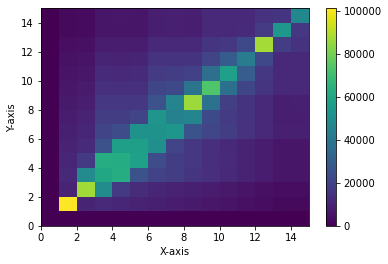

In [6]:
print(len(resampled_data))
lengths2=[]
for point in resampled_data:
    lengths2.append(find_int_lengths(point[0]))
x, y = zip(*lengths2)

# Create the 2D histogram
plt.hist2d(x, y, bins=(15, 15), range=[[0, 15], [0, 15]])

# Adding color bar to the right
plt.colorbar()

# Adding labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()

In [7]:
resampled_dataset=[]
for point in resampled_data:
    resampled_dataset.append({'input':point[0],'output':point[1]})

In [8]:
import json
with open("recursive_addition_resampled_test.json", "w") as f:
    json.dump(resampled_dataset, f, indent=4)